# Summary

This document contains all the steps relevant to feature engineering. Now that the data is clean, I will comb through Trump's tweets to look for patterns that might improve predictability. 

#### Update 10/28/18: 
Training on 2015 and 2016 data is highly nonrepresentative of Trump's future behavior, so the model performs very poorly with it. Therefore I need to remove those observations. That leaves a lot less data, but the model will still do better. 

### Import Packages, Load Data

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sns
# For removing and counting stopwords
from nltk.corpus import stopwords
# For lemmatization 
from textblob import TextBlob
from textblob import Word
# For idf and tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('~/Documents/GitHub/Trump-Twitter-Predictions/Data/abt.csv', encoding = 'ISO-8859-1')
# Filter out 2015 and 2016 data 
df = df[df.Year > 2016]
df.head()

,source,text,retweet_count,favorite_count,Followers,Follower_Change,Num_Tweets,Year,Month,Week,Day,Hour,Holiday
0,Twitter for iPhone,Judge Kavanaugh showed America exactly why I n...,85502,320158,54672474.0,21128.0,12,2018,9,39,27,22,0
1,Twitter for iPhone,https://t.co/9o5gZlJiTd,17391,77145,54651346.0,20751.0,13,2018,9,39,26,23,0
2,Twitter for iPhone,Join me this Saturday in Wheeling West Virgini...,14484,52957,54651346.0,20751.0,13,2018,9,39,26,20,0
3,Twitter for iPhone,Congressman Lee Zeldin is doing a fantastic jo...,14949,65494,54651346.0,20751.0,13,2018,9,39,26,17,0
4,Twitter for iPhone,China is actually placing propaganda ads in th...,19236,58671,54651346.0,20751.0,13,2018,9,39,26,17,0


Very small dataset. 

In [3]:
df.shape

(4325, 13)

# Basic Feature Extraction From Text

I want to extract features such as the number of words, and the average length of the words Trump uses. However, this means that I don't want there to be urls in the tweets I'm deriving these counts for, so I need to make a new column that is free of urls. 

### Remove URLS

In [4]:
df['trump_text'] = df.text.str.replace(r'http\S+', '')

In [5]:
df['Word_Count'] = df.trump_text.apply(lambda x: len(str(x).split(' ')))
df[['Word_Count', 'trump_text']].head()

,Word_Count,trump_text
0,42,Judge Kavanaugh showed America exactly why I n...
1,1,
2,13,Join me this Saturday in Wheeling West Virgini...
3,34,Congressman Lee Zeldin is doing a fantastic jo...
4,41,China is actually placing propaganda ads in th...


### Indicator of URLs

It may be helpful to know whether or not a tweet has a url. We can create an indicator variable for it. 

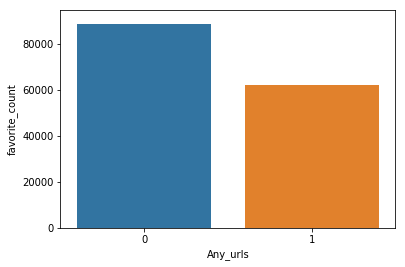

In [6]:
# Create column with all 0s
df['Any_urls'] = 0
# Find indices with 0s
indices_with_urls = df.text.str.extractall(r'(http\S+)').index.get_level_values(0)
# Make those indices 1
df.iloc[indices_with_urls, np.where(df.columns.isin(['Any_urls']))[0]] = 1

# Visualize median per group 
sns.barplot(x = df.Any_urls, y = df.favorite_count, estimator=np.median, errwidth=False)

### Number of Characters

In [7]:
df['Character_Count'] = df.trump_text.str.len()
df[['Character_Count', 'trump_text']].head()

,Character_Count,trump_text
0,264,Judge Kavanaugh showed America exactly why I n...
1,0,
2,67,Join me this Saturday in Wheeling West Virgini...
3,182,Congressman Lee Zeldin is doing a fantastic jo...
4,225,China is actually placing propaganda ads in th...


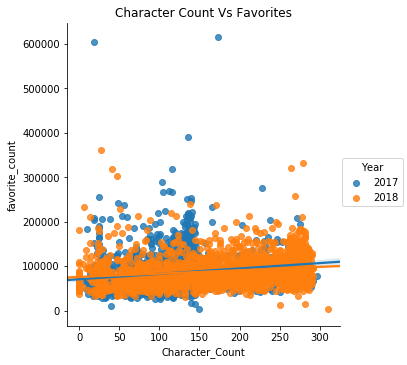

Correlation is: 0.17233491971200476


In [8]:
sns.lmplot(y = "favorite_count", x = "Character_Count", hue = 'Year', data = df)
plt.title('Character Count Vs Favorites')
plt.show()
print('Correlation is:', df[['favorite_count', 'Character_Count']].corr().iloc[1,0])

### Average Word Length

In [9]:
# Define function to generate avg_length
def avg_word_length(tweet): 
    words = tweet.split()
    if len(words) > 0:
        return(sum(len(word) for word in words) / len(words))
    else: 
        return(0)

df['avg_word_len'] = df.trump_text.apply(avg_word_length)

df[['avg_word_len', 'trump_text']].head()

,avg_word_len,trump_text
0,5.309524,Judge Kavanaugh showed America exactly why I n...
1,0.000000,
2,5.000000,Join me this Saturday in Wheeling West Virgini...
3,4.382353,Congressman Lee Zeldin is doing a fantastic jo...
4,4.625000,China is actually placing propaganda ads in th...


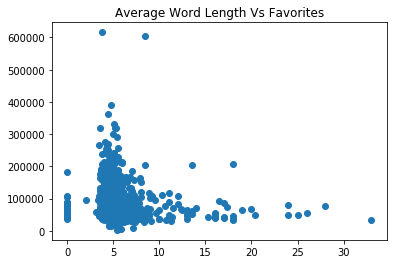

Correlation is: -0.12423630783835853


In [10]:
plt.scatter(y = "favorite_count", x = "avg_word_len", data = df)
plt.title('Average Word Length Vs Favorites')
plt.show()

print('Correlation is:', df[['favorite_count', 'avg_word_len']].corr().iloc[1,0])

### Number of Stopwords

In [11]:
swords = stopwords.words('english')
df['Num_Stopwords'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.lower() in swords]))
df[['Num_Stopwords', 'trump_text']].head()

,Num_Stopwords,trump_text
0,16,Judge Kavanaugh showed America exactly why I n...
1,0,
2,4,Join me this Saturday in Wheeling West Virgini...
3,18,Congressman Lee Zeldin is doing a fantastic jo...
4,18,China is actually placing propaganda ads in th...


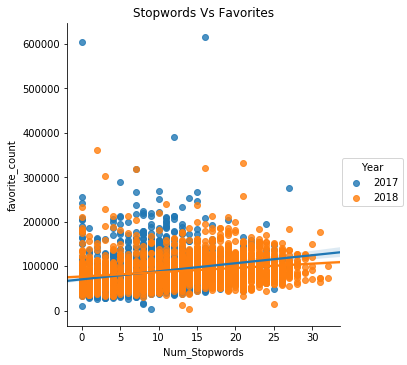

Correlation is: 0.2094088618778059


In [12]:
sns.lmplot(y = "favorite_count", x = "Num_Stopwords", hue = 'Year', data = df)
plt.title('Stopwords Vs Favorites')
plt.show()

print('Correlation is:', df[['favorite_count', 'Num_Stopwords']].corr().iloc[1,0])

### Number and Presence of Hashtags 

It may be helpful to know how many hashtags are in given tweets. Trump doesn't tweet too often with hashtags, so it might be more helpful to have an indicator variable simply demonstrating whether or not there are hashtags. 

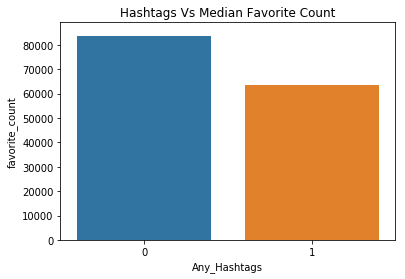

In [13]:
# Presence 
indices_with_hashtags = df.trump_text.str.extractall(r'(#)', re.IGNORECASE).index.get_level_values(0)
# Create an indicator variable, set all to 0 
df['Any_Hashtags'] = 0
# Set indices_with_hashtags to 1
df.iloc[indices_with_hashtags, np.where(df.columns.isin(['Any_Hashtags']))[0]] = 1

# Number
df['Num_Hashtags'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.startswith('#')]))

# Visualize presence 
sns.barplot(x = df.Any_Hashtags, y = df.favorite_count, estimator=np.median, errwidth=False)
plt.title('Hashtags Vs Median Favorite Count')
plt.show()

We can even see that when Trump does use hashtags, he typically uses 1. 

In [14]:
print('The mode hashtags when used is', df.Num_Hashtags[df.Num_Hashtags>0].mode().values)

The mode hashtags when used is [1]


### Number and Presence of Mentions

Again, we'll take a look at when (and how often) he uses mentions. 

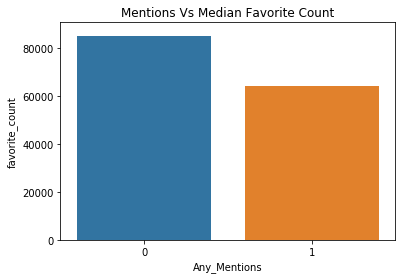

In [15]:
# Presence
indices_with_mentions = df.trump_text.str.extractall(r'(@)', re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Mentions'] = 0
# Set proper indices to 1
df.iloc[indices_with_mentions, np.where(df.columns.isin(['Any_Mentions']))[0]] = 1

# Number
df['Num_Mentions'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.startswith('#')]))

# Visualize mentions
sns.barplot(x = df.Any_Mentions, y = df.favorite_count, estimator=np.median, errwidth=False)
plt.title('Mentions Vs Median Favorite Count')
plt.show()

### Uppercase

Trump will often use his caps lock generously, either for entire tweets, or for emphasis purposes. I'll make an indicator variable for if a tweet is entirely in caps. This might be overkill, but I'd rather start off with more variables than fewer. 

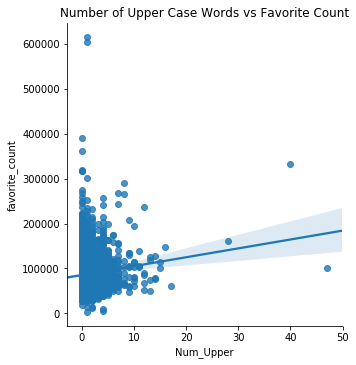

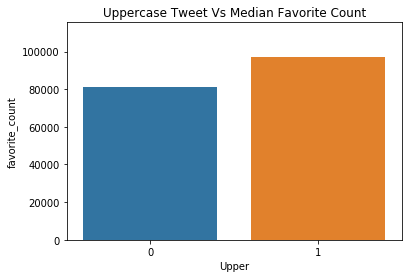

In [16]:
# Number a
df['Num_Upper'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.isupper() and len(word) > 1]))

# Presence of all-uppercase
df['Upper'] = df.trump_text.str.isupper().astype(int)

# Visualize number of upper
sns.lmplot(y='favorite_count', x = 'Num_Upper', data = df)
plt.title('Number of Upper Case Words vs Favorite Count')
plt.show()

# Visualize presence by median per group 
sns.barplot(x=df.Upper, y = df.favorite_count, estimator=np.median, errwidth=False)
plt.title('Uppercase Tweet Vs Median Favorite Count')
plt.show()


### Number of Exclamations 

Trump is an excitable guy. Tracking the number of exclamation marks per tweet might become useful. 

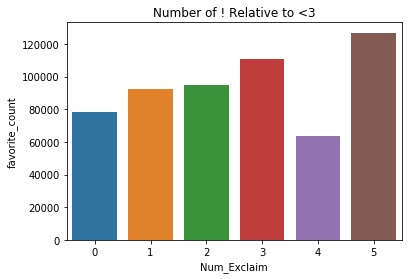

In [17]:
# Create column
df['Num_Exclaim'] = df.trump_text.apply(lambda x: len([word for word in x.split() if word.endswith('!')]))
# Visualize
sns.barplot(y = 'favorite_count', x = 'Num_Exclaim', data = df, errwidth=False)
plt.title('Number of ! Relative to <3')
plt.show()

### The Clintons 

Any mention of Hillary, or the Clintons. 

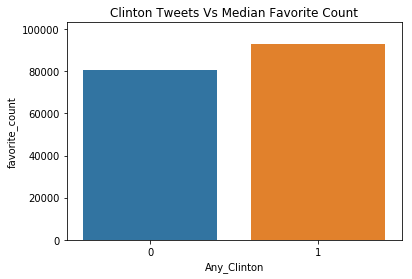

In [18]:
indices_with_clintons = df.trump_text.str.extractall(r'(hillary)|(hillary clinton)|(clinton)|(clintons)|(bill clinton)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Clinton'] = 0
# Set proper indices to 1
df.iloc[indices_with_clintons, np.where(df.columns.isin(['Any_Clinton']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_Clinton, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Clinton Tweets Vs Median Favorite Count')
plt.show()

### Obama

Any mention of Obama

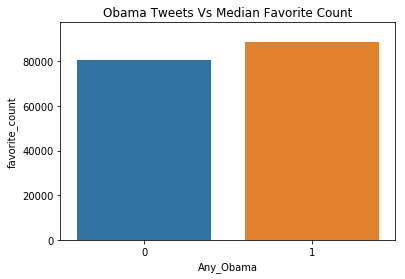

In [19]:
indices_with_obama = df.trump_text.str.extractall(r'(obama)|(barrack)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Obama'] = 0
# Set proper indices to 1
df.iloc[indices_with_obama, np.where(df.columns.isin(['Any_Obama']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_Obama, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Obama Tweets Vs Median Favorite Count')
plt.show()

### MAGA 

Any form of MAGA. 

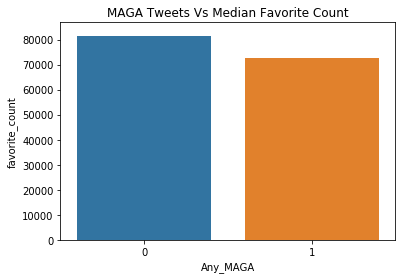

In [20]:
indices_with_maga = df.trump_text.str.extractall(r'(MAKE AMERICA GREAT AGAIN)|(MAGA)|(#MAKEAMERICAGREATAGAIN)|(#MAGA)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_MAGA'] = 0
# Set proper indices to 1
df.iloc[indices_with_maga, np.where(df.columns.isin(['Any_MAGA']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_MAGA, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('MAGA Tweets Vs Median Favorite Count')
plt.show()

### Sad/Bad

Any use of Sad or Bad

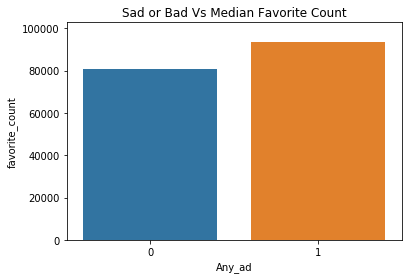

In [21]:
indices_with_ad = df.trump_text.str.extractall(r'(sad)|(bad)|(sad!)|(bad!)|(sad.)|(bad.)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_ad'] = 0
# Set proper indices to 1
df.iloc[indices_with_ad, np.where(df.columns.isin(['Any_ad']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_ad, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Sad or Bad Vs Median Favorite Count')
plt.show()

### Party Lines

Tweets about Democrats and Republicans. 

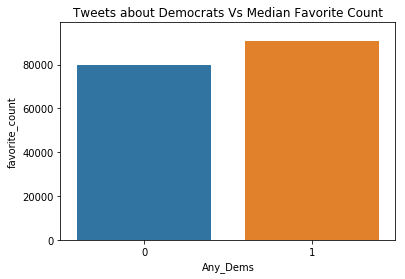

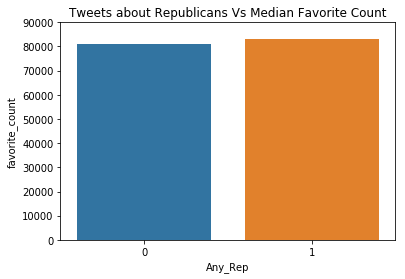

In [22]:
# Democrats
indices_with_dems = df.trump_text.str.extractall(r'(democrat)|(democratic)|(democrats)|(dems)|(dem)|(dnc)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Dems'] = 0
# Set proper indices to 1
df.iloc[indices_with_dems, np.where(df.columns.isin(['Any_Dems']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_Dems, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets about Democrats Vs Median Favorite Count')
plt.show()

# Republicans
indices_with_reps = df.trump_text.str.extractall(r'(republican)|(rep)|(gop)', 
                                                     re.IGNORECASE).index.get_level_values(0)
# Create indicator variable, set all to 0
df['Any_Rep'] = 0
# Set proper indices to 1
df.iloc[indices_with_reps, np.where(df.columns.isin(['Any_Rep']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_Rep, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets about Republicans Vs Median Favorite Count')
plt.show()

I'll remove these columns. 

In [23]:
df.drop(columns=['Any_Rep', 'Any_Dems'], axis = 1, inplace=True)

### Mention of Fake News/Media 

Trump is highly critical of many media platforms, and often takes to Twitter to vocalize his criticism. I want to see how mentions of fake news and the media perform relative to other tweets. 

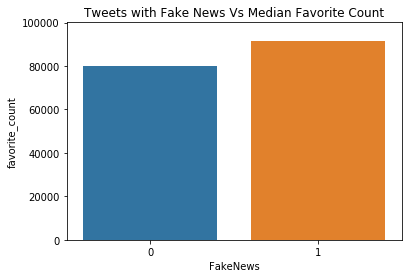

In [24]:
# Find indices where fake news media is mentioned
indices_with_media = df.trump_text.str.extractall(r'(fakenews)|(fake news)|(media)|(fake)|(fakenews!)|(press)', 
                                                  re.IGNORECASE).index.get_level_values(0)

# Create column, set all = 0
df['FakeNews'] = 0

# Set those with mentions of fake news = 1
df.iloc[indices_with_media, np.where(df.columns.isin(['FakeNews']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.FakeNews, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets with Fake News Vs Median Favorite Count')
plt.show()

Does this pattern extend to anything Trump calls untruthful? For example, calling the Russia investigation a hoax. If so, I will add those indices to FakeNews. 

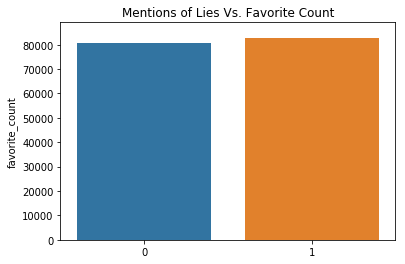

Number of tweets involving lies: 1353


In [25]:
# Indices involving lies
indices_mentioning_lies = df.trump_text.str.extractall(r'(liar)|(lie)|(false)|(faker)|(con)|(hoax)',
                                                      re.IGNORECASE).index.get_level_values(0)

# Set object to 0 
lies = np.repeat(0, len(df))
# Set lies with indices_mentioning_lies = 1
lies[indices_mentioning_lies] = 1

# Visualize
sns.barplot(x = lies, y = df.favorite_count, estimator = np.median, errwidth = False)
plt.title('Mentions of Lies Vs. Favorite Count')
plt.show()

print('Number of tweets involving lies:', len(indices_mentioning_lies))

No need to add these in. 

### Immigration 
Statements about Mexico, the wall, and immigration in general tend to be very popular with his base. I'll see if the data reflects that. 

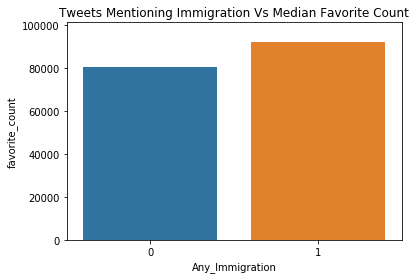

In [26]:
# Indices mentioning immigration related ideas 
indices_mentioning_immigrants = df.trump_text.str.extractall(r'(immigration)|(immigrants)|(border)|(wall)|(buildthewall)|(wall)|(thewall)|(caravan)',
                                                      re.IGNORECASE).index.get_level_values(0)

# Create column, set all = 0
df['Any_Immigration'] = 0

# Set those with mentions of fake news = 1
df.iloc[indices_mentioning_immigrants, np.where(df.columns.isin(['Any_Immigration']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Any_Immigration, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets Mentioning Immigration Vs Median Favorite Count')
plt.show()

Up until now I have been focusing on what makes tweets do well, but it is also important to check out what is predictive of a tweet performing poorly so as to not overestimate poorly performing tweets. 

### Join Me!

He often has tweets where he states "Join me in x location while I give a speech on y!" that tend to do poorly. 

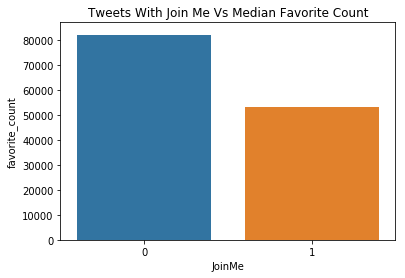

In [27]:
# Indices where he says join me
indices_with_joinme = df.trump_text.str.extractall(r'(join me)|(joining)|(interview)',
                                                      re.IGNORECASE).index.get_level_values(0)

# Create column, set all = 0
df['JoinMe'] = 0

# Set those with mentions = 1
df.iloc[indices_with_joinme, np.where(df.columns.isin(['JoinMe']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.JoinMe, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets With Join Me Vs Median Favorite Count')
plt.show()

He often tweets about press conferences he holds with other world leaders, which also tend to do poorly. 

### Press Conferences

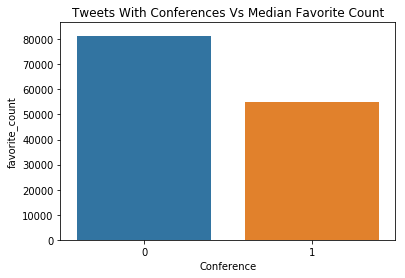

In [28]:
# Indices with press conferences 
indices_with_conference = df.trump_text.str.extractall(r'(press conference)|(conference)|(joint)',
                                                      re.IGNORECASE).index.get_level_values(0)

# Create column, set all = 0
df['Conference'] = 0

# Set those with mentions = 1
df.iloc[indices_with_conference, np.where(df.columns.isin(['Conference']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Conference, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets With Conferences Vs Median Favorite Count')
plt.show()

### Thank You Tweets

### Rallys
He often promotes rallies as well, which don't typically garner a ton of likes. There is probably overlap here with JoinMe, but we'll make it separate anyway.  

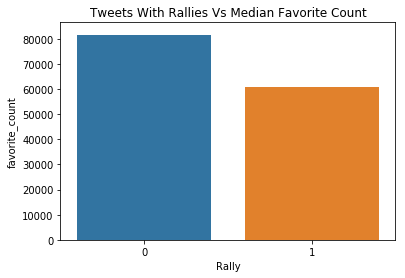

In [29]:
# Indices with issues
indices_with_rally = df.trump_text.str.extractall(r'(rally)',
                                                      re.IGNORECASE).index.get_level_values(0)

# Create column, set all = 0
df['Rally'] = 0

# Set those with mentions of fake news = 1
df.iloc[indices_with_rally, np.where(df.columns.isin(['Rally']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Rally, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets With Rallies Vs Median Favorite Count')
plt.show()

### Welcoming
Trump often welcomes world leaders. 

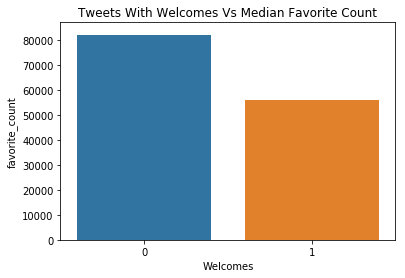

In [30]:
# Indices with welcomes
indices_with_welcomes = df.trump_text.str.extractall(r'(welcome)|(welcoming)',
                                                      re.IGNORECASE).index.get_level_values(0)

# Create column, set all = 0
df['Welcomes'] = 0

# Set those with mentions of fake news = 1
df.iloc[indices_with_welcomes, np.where(df.columns.isin(['Welcomes']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Welcomes, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets With Welcomes Vs Median Favorite Count')
plt.show()

### Violence

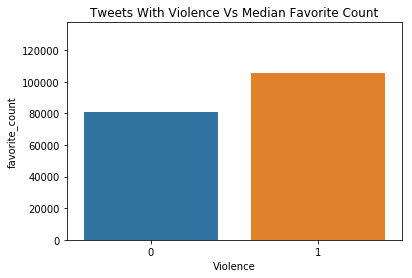

In [31]:
# Indices with thank yous
indices_with_violence = df.trump_text.str.extractall(r'(violence)|(violent)',
                                                      re.IGNORECASE).index.get_level_values(0)

# Create column, set all = 0
df['Violence'] = 0

# Set those with mentions of fake news = 1
df.iloc[indices_with_violence, np.where(df.columns.isin(['Violence']))[0]] = 1

# Visualize mentions
sns.barplot(x = df.Violence, y = df.favorite_count, estimator = np.median, errwidth=False)
plt.title('Tweets With Violence Vs Median Favorite Count')
plt.show()

# Advanced Text Analysis 

## Preprocessing 

In order to conduct more advanced natural language processing techniques, I need to clean the text data a bit. This includes making all words lowercase, removing punctuation, stopwords, most commonly occurring words, and words that occur only once. Then I proceed to lemmatize the tweets, which essentially reduces words to their root forms. 

In [32]:
# Lowercase
df.trump_text = df.trump_text.str.lower()

# Remove punctuation
df.trump_text = df.trump_text.str.replace(pat = '[^\w\s]', repl = '')

# Remove stopwords
df.trump_text = df.trump_text.apply(lambda x: ' '.join([word for word in x.split() if word not in swords]))

# Remove most commonly occuring words 
freq_words = list(pd.Series(' '.join(df['trump_text']).split()).value_counts()[:10].index)
df.trump_text = df.trump_text.apply(lambda x: ' '.join([word for word in x.split() if word not in freq_words]))

# Remove all words that were only used once 
infreq_words = pd.Series(' '.join(df['trump_text']).split()).value_counts()
infreq_words = infreq_words[infreq_words.values == 1]
infreq_words = list(infreq_words.index)
df.trump_text = df.trump_text.apply(lambda x: ' '.join([word for word in x.split() if word not in infreq_words]))

# Lemmatize
df.trump_text = df.trump_text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

## Algorithmic Text Processing

Here I will employ common algorithms to extract other features from the text.

### Term Frequency Rate (TF)

The term frequency rate for any given word is the number of times that word appears in a tweet divided by the number of words in the tweet. I will average the term frequency rate for all words per tweet.

In [33]:
# Function to find average term frequency rate per tweet
def avg_tf_rate(tweet):
    # For empty tweets (tweets that were likely just urls), mean tf = 0
    if len(tweet) == 0:
        return(0)
    # For actual tweets, calculate it out 
    else: 
        return(np.mean(pd.value_counts(tweet.split(' '))/len(tweet)))

# Create tf column 
df['tf'] = df.trump_text.apply(lambda x: avg_tf_rate(x))

### Inverse Document Frequency (IDF)

IDF of a word is defined as the log of the ratio of the total number of rows to the number of rows in which that word is present. I will average the IDF for all words per tweet. Higher IDF indicates more rarely used words. 

This will require the use of sklearn's Tfidvectorizer function. Since I'm finding the idf for every word, I'll create a dataframe that includes 

In [34]:
# Create tfidf vectorizer
vectorizer = TfidfVectorizer(lowercase=True, analyzer='word', ngram_range=(1,1))
# Fit the vocabulary 
idf_fit = vectorizer.fit(df.trump_text)
# Use the fit to find idf per phrase - save into a dataframe 
idf_df = pd.DataFrame({'Phrase': idf_fit.get_feature_names(), 'IDF': idf_fit.idf_})

In [35]:
def avg_idf_rate(tweet):
    # Tokenize the tweet
    tokenized_tweet = tweet.split(' ')
    # Find the idf per word using the idf_df 
    idf = idf_df[idf_df.Phrase.isin(tokenized_tweet)].IDF.values
    # Safeguard against empty lists - that means idf = 0
    if len(idf) == 0:
        return(0)
    else: 
        # Otherwise, return the average 
        return(np.mean(idf))
    
df['idf'] = df.trump_text.apply(lambda x: avg_idf_rate(x))

### TF-IDF

The TF-IDF of a word is simply the TF multiplied by the IDF. 

In [36]:
df['tfidf'] = df.tf * df.idf

### Checking Median of TF and IDF

I'm concerned that the mean TF and mean IDF aren't great representations in case they are skewed distributions. I'll check the difference between what I calculated and the median TF/IDF to see if the mean was a proper measure of center. 

In [37]:
# Function to find median term frequency rate per tweet
def med_tf_rate(tweet):
    # For empty tweets (tweets that were likely just urls), mean tf = 0
    if len(tweet) == 0:
        return(0)
    # For actual tweets, calculate it out 
    else: 
        return(np.median(pd.value_counts(tweet.split(' '))/len(tweet)))

# Median tf
med_tf = df.trump_text.apply(lambda x: med_tf_rate(x))

# Function to find median idf per tweet 
def med_idf_rate(tweet):
    # Tokenize the tweet
    tokenized_tweet = tweet.split(' ')
    # Find the idf per word using the idf_df 
    idf = idf_df[idf_df.Phrase.isin(tokenized_tweet)].IDF.values
    # Safeguard against empty lists - that means idf = 0
    if len(idf) == 0:
        return(0)
    else: 
        # Otherwise, return the average 
        return(np.median(idf))
# Median idf    
med_idf = df.trump_text.apply(lambda x: med_idf_rate(x))

In [38]:
print('The median TF is, on average, {}% different from the mean'.format(np.round(np.mean((df.tf - med_tf)/df.tf)*100)))
print('The median IDF is, on average, {}% different from the mean'.format(np.round(np.mean((df.idf - med_idf)/df.idf)*100)))

The median TF is, on average, 3.0% different from the mean
The median IDF is, on average, 1.0% different from the mean


Given that they are so close, I'll stick with the mean as the measure for TF and IDF, and keep the columns as they are. Here they are relative to the favorite_count - they appear to show distinct patterns. 

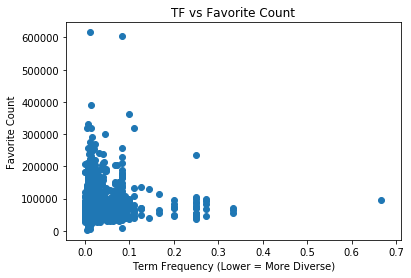

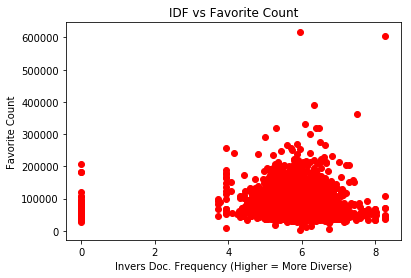

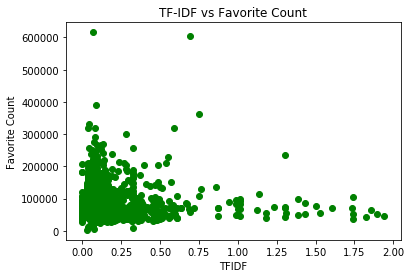

In [39]:
# TF vs Favorite Count
plt.scatter(df.tf, df.favorite_count)
plt.title('TF vs Favorite Count')
plt.xlabel('Term Frequency (Lower = More Diverse)')
plt.ylabel('Favorite Count')
plt.show()

# IDF vs Favorite Count
plt.scatter(df.idf, df.favorite_count, c = 'r')
plt.title('IDF vs Favorite Count')
plt.xlabel('Invers Doc. Frequency (Higher = More Diverse)')
plt.ylabel('Favorite Count')
plt.show()

# TFIDF vs Favorite Count
plt.scatter(df.tfidf, df.favorite_count, c = 'g')
plt.title('TF-IDF vs Favorite Count')
plt.xlabel('TFIDF')
plt.ylabel('Favorite Count')
plt.show()

### Sentiment Analysis
#### Polarity - Positivity Vs Negativity

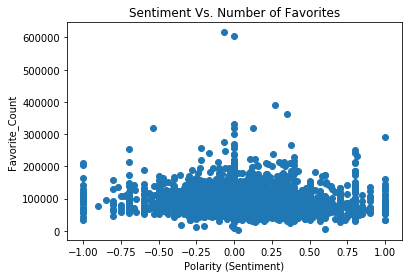

Correlation is: -0.06995429352383281


In [40]:
df['Sentiment'] = df.trump_text.apply(lambda x: TextBlob(x).sentiment[0])
plt.scatter(df.Sentiment, df.favorite_count)
plt.xlabel('Polarity (Sentiment)')
plt.ylabel('Favorite_Count')
plt.title('Sentiment Vs. Number of Favorites')
plt.show()
print('Correlation is:', df[['favorite_count', 'Sentiment']].corr().iloc[1,0])

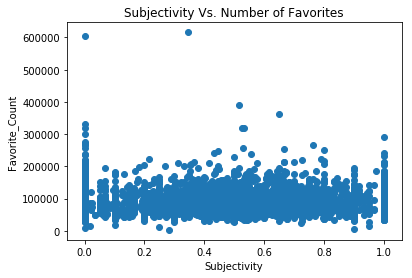

Correlation is: 0.10681002358138295


In [41]:
df['Subjectivity'] = df.trump_text.apply(lambda x: TextBlob(x).sentiment[1])
plt.scatter(df.Subjectivity, df.favorite_count)
plt.xlabel('Subjectivity')
plt.ylabel('Favorite_Count')
plt.title('Subjectivity Vs. Number of Favorites')
plt.show()
print('Correlation is:', df[['favorite_count', 'Subjectivity']].corr().iloc[1,0])

It appears as though there isn't a strong relationship between either of these features and favorite_count, but we'll keep them in anyway. 

# Final Steps

The data is just about ready for machine learning. The last thing I'll do here is remove irrelevant columns and an irrelevant observation. 

The observation I will remove is Trump's most liked tweet ever, which is the tweet he made after winning the presidential election. The reason for this is twofold: 
    1. Winning the election is a monumental event that is not going to be duplicated for many tweets. 
    2. Few features can capture what caused this massive response, and so it can truly be considered an outlier as far as this data is concerned. 

For columns, I will remove the text, since those can't be processed by the algorithms. I will also remove the retweet_count and source, since I won't have retweet_counts for tweets when predicting their outcome, and since I might not be able to obtain source in the future. 

In [42]:
df = df[df.favorite_count != df.favorite_count.max()]

In [43]:
df.columns

Index(['source', 'text', 'retweet_count', 'favorite_count', 'Followers',
       'Follower_Change', 'Num_Tweets', 'Year', 'Month', 'Week', 'Day', 'Hour',
       'Holiday', 'trump_text', 'Word_Count', 'Any_urls', 'Character_Count',
       'avg_word_len', 'Num_Stopwords', 'Any_Hashtags', 'Num_Hashtags',
       'Any_Mentions', 'Num_Mentions', 'Num_Upper', 'Upper', 'Num_Exclaim',
       'Any_Clinton', 'Any_Obama', 'Any_MAGA', 'Any_ad', 'FakeNews',
       'Any_Immigration', 'JoinMe', 'Conference', 'Rally', 'Welcomes',
       'Violence', 'tf', 'idf', 'tfidf', 'Sentiment', 'Subjectivity'],
      dtype='object')

In [44]:
# Drop the columns
final_abt = df.drop(columns = ['source', 'text', 'retweet_count', 'trump_text'])

# Save the abt
final_abt.to_csv('~/Documents/GitHub/Trump-Twitter-Predictions/Data/final_abt.csv', index = False)

In [45]:
final_abt.head()

,favorite_count,Followers,Follower_Change,Num_Tweets,Year,Month,Week,Day,Hour,Holiday,...,JoinMe,Conference,Rally,Welcomes,Violence,tf,idf,tfidf,Sentiment,Subjectivity
0,320158,54672474.0,21128.0,12,2018,9,39,27,22,0,...,0,0,0,0,0,0.005376,6.474202,0.034808,0.12500,0.533333
1,77145,54651346.0,20751.0,13,2018,9,39,26,23,0,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.00000,0.000000
2,52957,54651346.0,20751.0,13,2018,9,39,26,20,0,...,1,0,0,0,0,0.025641,6.357383,0.163010,0.00000,0.000000
3,65494,54651346.0,20751.0,13,2018,9,39,26,17,0,...,0,0,0,0,0,0.010526,5.341097,0.056222,0.15873,0.665986
4,58671,54651346.0,20751.0,13,2018,9,39,26,17,0,...,0,0,0,0,0,0.008197,6.210913,0.050909,-0.05000,0.100000
